In [322]:
import pandas as pd
import os
from itertools import combinations
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from gurobipy import *

In [323]:
#create dictionary of airport data
#import the data
demand = 'DemandGroup3.xlsx'
df1 = pd.read_excel(demand, header=None)

#clean the dataframe
df1 = df1.drop(df1.index[9:12])
df1 = df1.drop(df1.index[0:3])
df1 = df1.drop(df1.columns[0], axis=1)
#df1 = df1.reset_index()

#make a list of airport names
airport_names = df1.iloc[0, 1:].dropna().tolist()
airport_codes = df1.iloc[1,1:].tolist()
#make a list of keys 
keys = df1.iloc[1:, 0].dropna().tolist()

#create dictionaries for each airport
airport_dictionaries = {}
for i, airport in enumerate(airport_codes):
# Extract values 
    values = df1.iloc[1:,i+1].dropna().tolist()
    # Map keys to values
    airport_dictionaries[airport] = dict(zip(keys, values))

In [324]:
#add population data to airports
#import population data
population = 'pop.xlsx'
df2 = pd.read_excel(population, header=None)

#make lists of additional data
pop20 = df2.iloc[3:,1].tolist()
pop23 = df2.iloc[3:,2].tolist()
gdp20 = df2.iloc[3:,5].tolist()
gdp23 = df2.iloc[3:,6].tolist()

for i, airport in enumerate(airport_codes):
    # Map keys to values
    airport_dictionaries[airport]['pop20'] = pop20[i]
    airport_dictionaries[airport]['pop23'] = pop23[i]
    airport_dictionaries[airport]['gdp20'] = gdp20[i]
    airport_dictionaries[airport]['gdp23'] = gdp23[i]

In [325]:
#Make a dataset for all OD pairs to estimate an OLS regression model using 2020 data
#create a list of sets of possible pairs
pairs = list(combinations(airport_codes, 2))

#Calculate demand between pairs
demands = []
for pair in range(len(pairs)):
    demands.append(airport_dictionaries[pairs[pair][0]][pairs[pair][1]])

#Calculate product of population
population_product = []
for pair in range(len(pairs)):
    population_product.append(airport_dictionaries[pairs[pair][0]]['pop20']*airport_dictionaries[pairs[pair][1]]['pop20'])
    
#Calculate product of GDP
gdp_product = []
for pair in range(len(pairs)):
    gdp_product.append(airport_dictionaries[pairs[pair][0]]['gdp20']*airport_dictionaries[pairs[pair][1]]['gdp20'])



In [326]:
#Create a function to calculate the distance between two airports using the coordinates in degrees
def calculate_distance(phi1, phi2, lamda1, lamda2):
    R_E = 6371 #km
    phi1 = np.radians(phi1)
    phi2 = np.radians(phi2)
    lamda1 = np.radians(lamda1)
    lamda2 = np.radians(lamda2)
    sigma = 2* np.arcsin(np.sqrt(np.sin((phi1 - phi2)/2)**2 + np.cos(phi1)*np.cos(phi2)*np.sin((lamda1 - lamda2)/2)**2))
    d_ij = R_E * sigma
    return float(d_ij)

In [327]:
#Calculate distance
distance = []
for pair in range(len(pairs)):
    distance.append(calculate_distance(airport_dictionaries[pairs[pair][0]]['Latitude (deg)'],
                                       airport_dictionaries[pairs[pair][1]]['Latitude (deg)'],
                                       airport_dictionaries[pairs[pair][0]]['Longitude (deg)'],
                                       airport_dictionaries[pairs[pair][1]]['Longitude (deg)']))
distance = np.array(distance)

In [328]:
#estimate OLS model
f = 1.42 #€/gallon fuel costs
#create dataset
ols_data = {
    'population_product': np.log(population_product),
    'gdp_product': np.log(gdp_product),
    'distance': np.log(f) + np.log(distance),
    'demand': np.log(demands) #dependent variable
}

ols_df = pd.DataFrame(ols_data)

In [329]:
# Define independent variables (X) and dependent variable (Y)
X = ols_df[['population_product', 'gdp_product', 'distance']] 
Y = ols_df['demand']  

# Initialize and fit the Linear Regression model
model = LinearRegression()
model.fit(X, Y)

# Coefficients and intercept
print("Intercept:", model.intercept_)
print("Coefficients:", model.coef_)

# Predict values
predictions = model.predict(X)
print("Predicted values:", predictions)

Intercept: -16.3862350654871
Coefficients: [ 0.58638073  0.63171159 -1.24424231]
Predicted values: [ 7.18466786  6.60962763  5.71702539  5.62860045  5.33123691  5.65847551
  5.45001298  6.12608816  4.98271261  4.02904107  6.17053776  4.40197896
  4.49359179  5.717942    3.84947441  2.80213011  3.36943321  4.31315834
  3.11970374  5.79197794  5.45885274  5.09687065  4.96459464  5.33301613
  5.06014717  4.70418476  4.19163001  3.37858907  5.57703634  3.6427828
  3.87860142  4.38387853  3.28179075  2.23315111  2.43317235  3.84645124
  2.41753752  5.21693895  4.20895754  4.01204124  4.87092346  4.36184737
  4.26634122  4.0576717   2.60069471  5.56294389  3.42217252  3.63087884
  4.21949526  2.83336005  1.69233157  2.05729     3.17709175  1.74990337
  4.05835029  3.98555471  5.67969746  4.55452734  3.62105401  3.79951693
  2.39833051  5.7425843   3.22470567  3.70315627  3.49027137  2.9076122
  1.70731395  1.66908602  3.26318227  1.54270228  5.7146549   4.38793248
  4.85892155  3.9708913   3

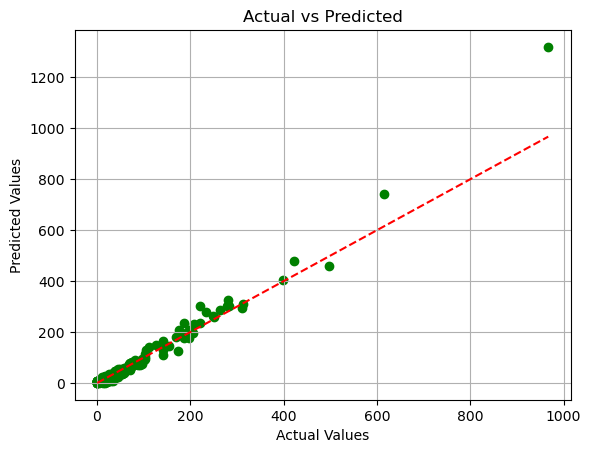

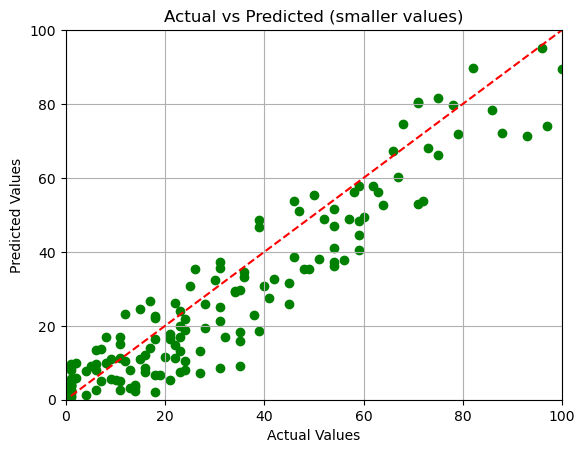

In [331]:
#plot actual agains predicted values

# Sample data
actual = demands
predicted = np.exp(predictions)

# Scatter plot for all values
plt.figure()
plt.scatter(actual, predicted, color='green')
plt.plot([min(actual), max(actual)], [min(actual), max(actual)], color='red', linestyle='--')  # Diagonal line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid()
plt.title('Actual vs Predicted')
plt.show()

# Scatter plot zoomed in on the smaller values
plt.figure()
plt.scatter(actual, predicted, color='green')
plt.plot([min(actual), max(actual)], [min(actual), max(actual)], color='red', linestyle='--')  # Diagonal line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid()
plt.xlim(0,100)
plt.ylim(0,100)
plt.title('Actual vs Predicted (smaller values)')
plt.show()

In [332]:
#calculate the values for population and gdp for 2025
annual_growth_pop = (np.array(pop23) - np.array(pop20))/3
pop25 = np.array(pop23) + 2*annual_growth_pop

annual_growth_gdp = (np.array(gdp23) - np.array(gdp20))/3
gdp25 = np.array(gdp23) + 2*annual_growth_gdp

#Add to dictionaries
for i, airport in enumerate(airport_codes):
    # Map keys to values
    airport_dictionaries[airport]['pop25'] = pop25[i]
    airport_dictionaries[airport]['gdp25'] = gdp25[i]

In [333]:
#Calculate product of population
population_product25 = []
for pair in range(len(pairs)):
    population_product25.append(airport_dictionaries[pairs[pair][0]]['pop25']*airport_dictionaries[pairs[pair][1]]['pop25'])
    
#Calculate product of GDP
gdp_product25 = []
for pair in range(len(pairs)):
    gdp_product25.append(airport_dictionaries[pairs[pair][0]]['gdp25']*airport_dictionaries[pairs[pair][1]]['gdp25'])

In [334]:
ols_data_25 = pd.DataFrame({
    'population_product': np.log(population_product25),
    'gdp_product': np.log(gdp_product25),
    'distance': np.log(f*distance),
})
predictions2025 = model.predict(ols_data_25)
predictions2025 = np.exp(predictions2025)
print("Predicted Values:", predictions2025)

Predicted Values: [1.36130328e+03 8.51547280e+02 3.78998523e+02 2.73341598e+02
 2.03939264e+02 3.61190288e+02 2.34975389e+02 7.66559966e+02
 1.75289870e+02 6.15152310e+01 6.03240164e+02 9.48364009e+01
 1.09186092e+02 3.47738202e+02 6.36207286e+01 1.26886572e+01
 5.33162102e+01 7.41460437e+01 2.22013031e+01 3.23102955e+02
 2.51621342e+02 1.38042026e+02 1.21479514e+02 2.24193886e+02
 1.36753584e+02 1.58947700e+02 6.83009784e+01 2.75884855e+01
 2.86397200e+02 3.81498889e+01 5.07356595e+01 7.87243193e+01
 3.09948594e+01 6.17368030e+00 1.79671527e+01 3.99606532e+01
 9.45506384e+00 2.19622240e+02 6.31518724e+01 5.20960784e+01
 1.57011022e+02 7.56243478e+01 1.14049106e+02 6.64110340e+01
 1.40891016e+01 3.13934588e+02 3.40152856e+01 4.40270347e+01
 7.42521169e+01 2.20054050e+01 3.99631643e+00 1.37159629e+01
 2.27469993e+01 5.39144662e+00 5.90281691e+01 5.51293734e+01
 3.83051532e+02 9.96374190e+01 6.50022199e+01 5.57450135e+01
 1.25048540e+01 4.08260145e+02 3.03386558e+01 5.14268709e+01
 3.891

In [335]:
#Make a dictionary mapping the distances to the pairs
pair_distances = dict(zip(pairs, distance))

#Make a dictionary mapping the demand to the pair
pair_demands = dict(zip(pairs, predictions2025))

In [336]:
#Make a matrix of all airports
distance_airport_matrix = np.zeros((20, 20))

#Calculate the distance of the pairs
for a1, a2 in pairs:    
    i, j = airport_codes.index(a1), airport_codes.index(a2)
    distance_airport_matrix[i, j] = pair_distances[(a1,a2)]  # Mark connection
    distance_airport_matrix[j, i] = pair_distances[(a1,a2)]  # Since connections are bidirectional

#Convert to Pandas DataFrame for better readability
df_airport_matrix = pd.DataFrame(distance_airport_matrix, index=airport_codes, columns=airport_codes)

# Display the matrix
print(distance_airport_matrix)

[[   0.          347.16728652  370.44940214  654.76363325 1245.95254754
  1147.71336475  941.58024305 1443.88573564  449.25564358 1462.53795599
  1563.9299774   947.24445701 1847.95556624 1469.60459235  533.53024673
  2103.79601784 2714.67635569 1894.99443696 1834.23944276 2471.39782873]
 [ 347.16728652    0.          398.2697513   449.00506895 1064.51428765
   858.73809944  681.56929333 1100.69283994  784.9693369  1539.15551784
  1469.96328629  850.49749711 1895.55823446 1342.49303513  868.67686391
  1850.13354288 2389.84447093 2241.07711568 1487.34007964 2421.48814977]
 [ 370.44940214  398.2697513     0.          366.57748719 1460.65548282
  1241.135764    664.16582895 1296.81843728  750.16225603 1152.16825865
  1846.2966304   578.1866549  1521.30336778 1101.16931458  666.36363163
  1783.20374812 2480.93415416 2037.66213469 1712.07150053 2783.50332308]
 [ 654.76363325  449.00506895  366.57748719    0.         1422.05057215
  1093.61140292  299.07364935  958.12971616 1086.89401961 122

In [337]:
#Make a matrix for the demand    
demand_airport_matrix = np.zeros((20, 20))

#Calculate the demands of the pairs
for a1, a2 in pairs:    
    i, j = airport_codes.index(a1), airport_codes.index(a2)
    demand_airport_matrix[i, j] = pair_demands[(a1,a2)] 
    demand_airport_matrix[j, i] = pair_demands[(a1,a2)] 

#Runway length airports
r_length = np.zeros(20)
for i in airport_codes:
    r_length[airport_codes.index(i)] = airport_dictionaries[i]['Runway (m)']

#Airport slots
slots= np.zeros(20)
for i in airport_codes:
    if i != 'LEMF':
        slots[airport_codes.index(i)] = airport_dictionaries[i]['Available slots']

In [338]:
# Parameters

# Data on aircrafts
aircraft = [1, 2, 3, 4] #Set of aircraft
s = [45, 70, 150, 320] #Seats
V = [550, 820, 850, 870] #Speed in km/h
TAT = [25, 35, 45, 60] #Min turnaround time in minutes
r = [1500, 3300, 6300, 12000] #Max range in km of aircraft
rr = [1400, 1600, 1800, 2600] #Required runway for a specific aircraft
c = [15000, 34000, 80000, 190000] #Weekly leasing costs
c_x = [300, 600, 1250, 2000] #Fixed costs per aircraft
c_t = [750, 775, 1400, 2800] #Time based costs /h
c_f = [1, 2, 3.75, 9] #Fuel cost parameter
BT = 10 * 7  #hours per day
LF = 0.75 #Load factor in an aircraft     

# Data on airports
Airports = airport_codes #List of airports
airports = range(len(Airports)) #Number of airports
r_length = r_length #Runway length at specific airport

#General data
d = distance_airport_matrix #Distance between airports  
q = demand_airport_matrix #Demand for flight between airport i and airport j
a = np.zeros((20,20,4)) #Empty array
g = np.ones(20) #Initialize array for hub parameter
g[4] = 0 #Madrid is our hub


# Calculating costs for use in model
c_ops = np.zeros((20,20,4)) #empty array for operational costs 

#Calculate operational costs for each aircraft and each OD-pair
for k in range(len(aircraft)):
    for i in airports:
        for j in airports:
            if i != j:
                c_ops[i][j][k] = (c_x[k]) + (c_t[k]*d[i][j]/V[k]) + (((c_f[k]*f)/1.5)*d[i][j])

#Flights departing or arriving at hub madrid have lower costs
for k in range(len(aircraft)):
    for i in airports:
        for j in airports:
            if i != j:
                if i == 4 or j == 4:
                    c_ops[i][j][k] = 0.7 * c_ops[i][j][k]

#Yield per OD pair
y = np.zeros((20,20))
for i in airports:
    for j in airports:
        if i !=j:
            y[i][j] = 5.9 * (d[i][j] **-.76) + 0.043 

In [339]:
# Start modelling optimization problem
m = Model('fleet_network')

# Decision variables
x = {} #Direct flow between airports i and j
z = {} #Number of flights between airports i and j
w = {} #Flow transferring at hub
ac = {} #Number of aircraft

# Sets
I = range(len(airport_codes))
J = I
K = range(len(aircraft))

# Initialize variables
for i in I:
    for j in J:
        if i != j:  # Exclude self-loops
            x[i, j] = m.addVar(obj=y[i][j] * d[i][j], lb=0, vtype=GRB.INTEGER, name=f"x_{i}_{j}")
            w[i, j] = m.addVar(obj=y[i][j] * d[i][j], lb=0, vtype=GRB.INTEGER, name=f"w_{i}_{j}")

for i in I:
    for j in J:
        for k in K:
            if i != j:  
                z[i, j, k] = m.addVar(
                    obj = -c_ops[i][j][k], lb=0, vtype=GRB.INTEGER, name=f"z_{i}_{j}_{k}"
                )

for k in K:
    ac[k] = m.addVar(obj = -c[k], lb=0, vtype=GRB.INTEGER, name=f"ac_{k}")

m.update()
m.setObjective(m.getObjective(), GRB.MAXIMIZE)   # The objective is to maximize profit

# Add constraints
# C1: demand verification
for i in airports:
    for j in airports:
        if i != j:
            # C1a: the direct flow and transferring flow should never exceed the demand
            m.addConstr(x[i, j] + w[i, j] <= q[i][j])
            
            # C1b: the transferring flow should not exceed the demand of the hub
            m.addConstr(w[i, j] <= q[i][j] * g[i] * g[j])
            
# C2: the flows within an aircraft should not exceed the seats of an aircraft
            m.addConstr(
                x[i, j]
                + quicksum(w[i, m] * (1 - g[j]) for m in I if (i, m) in w)
                + quicksum(w[m, i] * (1 - g[j]) for m in I if (m, i) in w)
                <= quicksum(z[i, j, k] * s[k] * LF for k in K if (i, j, k) in z)
            )

#C3: The number of flights incoming should be the same as the number of flights outgoing        
for i in airports:
    for k in range(len(aircraft)):
        m.addConstr(quicksum(z[i, j, k] for j in J if (i, j, k) in z)
                    - quicksum(z[j, i, k] for j in J if (j, i, k) in z) == 0)
       
#C4: Productivity constraint; the hours of operation should not exceed the availability of the aircraft   
for k in range(len(aircraft)):
    m.addConstr(quicksum((d[i][j] / V[k] + (TAT[k]/60 * 1.5 * (1-g[j]) + TAT[k]/60 * (g[j]))) * z[i, j, k] 
                 for i in I for j in J if (i, j, k) in z)
        <= BT * ac[k])   

#C5a: The distance of a flight shall not exceed the range of an aircraft  
#C5b: The runway of a specific airport shall not be shorter than the required runway of an aircraft
for i in airports:
    for j in airports: 
        for k in range(len(aircraft)):
            if d[i][j] <= r[k]:    #C5a
                a[i][j][k] = 1000000               
            if rr[k] <= r_length[i] or rr[k] <= r_length[j]: #C5b
                a[i][j][k] = 1000000
            else:
                 a[i][j][k] = 0
                                     
for i in airports:
    for j in airports: 
        for k in range(len(aircraft)):
            if i != j:
                m.addConstr(z[i,j,k] <= a[i][j][k])  

#C6: The maximum amount of slots cannot be exceeded
#for i in I:
#    for j in J:
#        if i!=j :
#            if i != 4 and j != 4:
#                m.addConstr(quicksum(z[i,j,k] for i in I if (i, j, k) in z) <=  slots[i])

m.update()
m.write('test.lp')
# Set time constraint for optimization (5minutes)
# m.setParam('TimeLimit', 1 * 60)
# m.setParam('MIPgap', 0.009)
m.optimize()
#m.write("testout.sol")
status = m.status

if status == GRB.Status.UNBOUNDED:
    print('The model cannot be solved because it is unbounded')

elif status == GRB.Status.OPTIMAL or True:
    f_objective = m.objVal
    print('** RESULTS ***')
    print('\nObjective Function Value: \t %g' % f_objective)

elif status != GRB.Status.INF_OR_UNBD and status != GRB.Status.INFEASIBLE:
    print('Optimization was stopped with status %d' % status)

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 2744 rows, 2284 columns and 9846 nonzeros
Model fingerprint: 0x60370dc2
Variable types: 0 continuous, 2284 integer (0 binary)
Coefficient statistics:
  Matrix range     [9e-01, 2e+02]
  Objective range  [4e+01, 2e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+06]
Found heuristic solution: objective -0.0000000
Presolve removed 1946 rows and 88 columns
Presolve time: 0.02s
Presolved: 798 rows, 2196 columns, 7563 nonzeros
Variable types: 0 continuous, 2196 integer (12 binary)

Root relaxation: objective 2.964546e+04, 865 iterations, 0.02 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 29

 2264603 253925 23151.3477   73   17 23114.4309 23151.8199  0.16%   5.3  210s
 2308451 253052 23132.3539   81   29 23114.4309 23151.3436  0.16%   5.3  215s
 2353055 251968     cutoff   72      23114.4309 23150.8584  0.16%   5.3  220s
 2398462 250806     cutoff   80      23114.4309 23150.3754  0.16%   5.3  225s
 2445215 249341 23145.5895   71   18 23114.4309 23149.8741  0.15%   5.3  230s
 2497772 247194     cutoff   80      23114.4309 23149.3012  0.15%   5.3  235s
 2546383 244786     cutoff   76      23114.4309 23148.7505  0.15%   5.3  240s
 2597000 242194 23117.7032   75   22 23114.4309 23148.1919  0.15%   5.3  245s
 2641854 239608     cutoff   75      23114.4309 23147.7068  0.14%   5.3  250s
 2689950 236639     cutoff   82      23114.4309 23147.1631  0.14%   5.3  255s
 2732923 233565 23134.8444   76   22 23114.4309 23146.6679  0.14%   5.3  260s
 2778168 230362 23122.5140   80   25 23114.4309 23146.1594  0.14%   5.3  265s
 2824611 226849     cutoff   75      23114.4309 23145.6391  0.14

In [340]:
#Print results

print()
print("Frequencies:----------------------------------")
print()
for i in airports:
    for j in airports:
        for k in range(4):
            if i != j:
                if z[i,j,k].X >0:
                    print(airport_names[i], ' to ', airport_names[j], 'with type ', aircraft[k], z[i, j, k].X)
                    print(ac[k])


Frequencies:----------------------------------

London  to  Paris with type  1 21.0
<gurobi.Var ac_0 (value 1.0)>
London  to  Paris with type  2 7.0
<gurobi.Var ac_1 (value 1.0)>
London  to  Paris with type  3 2.0
<gurobi.Var ac_2 (value 1.0)>
London  to  Amsterdam with type  3 4.0
<gurobi.Var ac_2 (value 1.0)>
London  to  Madrid with type  2 1.0
<gurobi.Var ac_1 (value 1.0)>
London  to  Madrid with type  3 2.0
<gurobi.Var ac_2 (value 1.0)>
London  to  Dublin with type  3 6.0
<gurobi.Var ac_2 (value 1.0)>
Paris  to  London with type  1 21.0
<gurobi.Var ac_0 (value 1.0)>
Paris  to  London with type  2 7.0
<gurobi.Var ac_1 (value 1.0)>
Paris  to  London with type  3 2.0
<gurobi.Var ac_2 (value 1.0)>
Paris  to  Amsterdam with type  3 2.0
<gurobi.Var ac_2 (value 1.0)>
Paris  to  Frankfurt with type  3 2.0
<gurobi.Var ac_2 (value 1.0)>
Paris  to  Madrid with type  3 1.0
<gurobi.Var ac_2 (value 1.0)>
Amsterdam  to  London with type  3 4.0
<gurobi.Var ac_2 (value 1.0)>
Amsterdam  to  Paris w

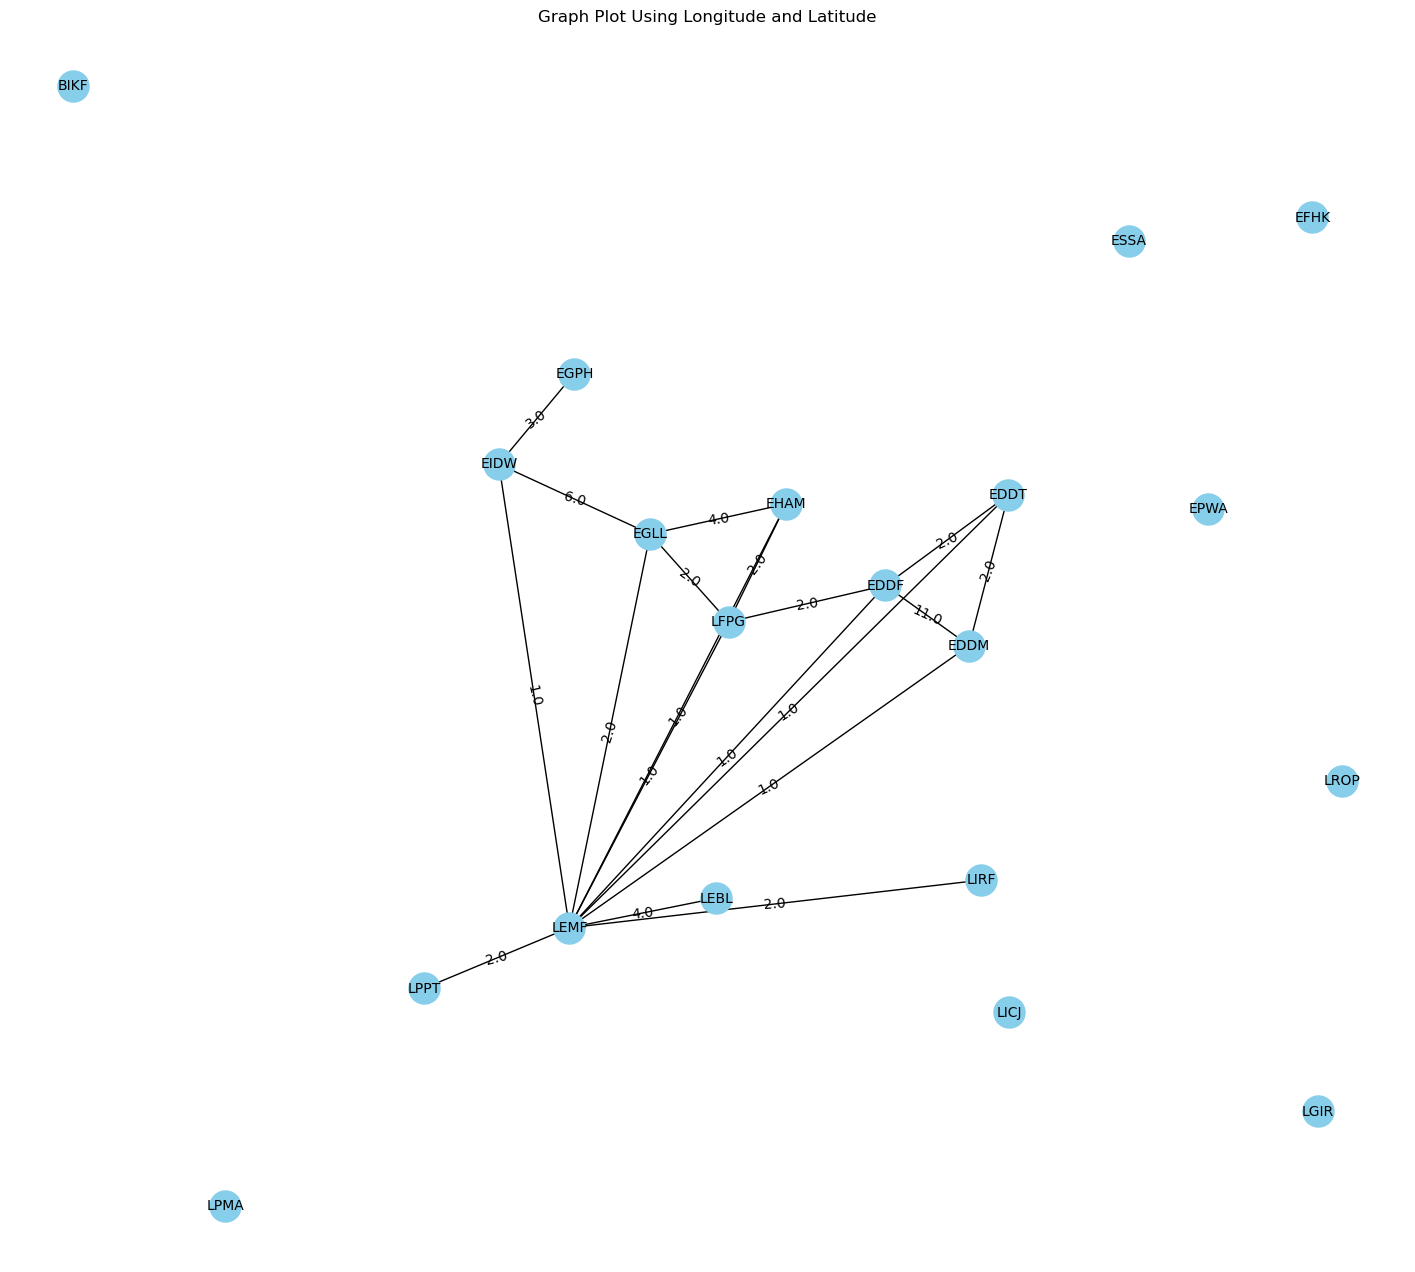

In [341]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a graph
G = nx.Graph()

for airport in airport_codes:
    airport_dictionaries[airport]['coordinates'] = (airport_dictionaries[airport]['Longitude (deg)'], 
                                                  airport_dictionaries[airport]['Latitude (deg)'])
    G.add_node(airport, pos = airport_dictionaries[airport]['coordinates'])
# Example edges
#edges = [("A", "B"), ("B", "C"), ("C", "D"), ("A", "D")]

for i in N:
    for j in N:
        for k in K:
            if i != j:
                if z[i,j,k].X > 0:
                    G.add_edge(airport_codes[i], airport_codes[j], weight = z[i,j,k].X)



# Add edges
#G.add_edges_from(edges)

# Extract positions for plotting
positions = nx.get_node_attributes(G, 'pos')

# Plot the graph
plt.figure(figsize=(18, 16))
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos=positions, edge_labels=edge_labels, font_size=10)
nx.draw(G, pos=positions, with_labels=True, node_size=500, node_color="skyblue", font_size=10)
plt.title("Graph Plot Using Longitude and Latitude")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

In [405]:
#assignment 2
#import data from excel
group3 = 'Group_3.xlsx'
df_flight = pd.read_excel(group3, sheet_name='Flights', header=0)
df_itineraries = pd.read_excel(group3, sheet_name='Itineraries', header=0).fillna(0)
df_recapture = pd.read_excel(group3, sheet_name='Recapture', header=0)
df_recapture

,From Itinerary,To Itinerary,Recapture Rate
0,0,1,0.21
1,0,6,0.24
2,0,7,0.37
3,0,11,0.34
4,1,2,0.37
...,...,...,...
160,90,115,0.58
161,93,92,0.50
162,106,80,0.58
163,106,83,0.67


In [528]:
#define sets
L_no = np.array(df_flight['Flight No.'])
L = range(len(L_no))
P = np.array(range(117))
P_p = df_recapture.groupby("From Itinerary")["To Itinerary"].apply(list).to_dict()
for i in range(117):
    if i not in P_p:
        P_p[i] = []  # Create an empty list if the key doesn't exist
        
for i in range(117):
    P_p[i].append(i)

P_p_data = df_recapture.iloc[:,:3].to_numpy()

#define parameters
fare = np.array(df_itineraries['Price [EUR]'])
D = np.array(df_itineraries['Demand'])
CAP = np.array(df_flight['Capacity'])

#for the recapture rate, make a 2d array
b = np.zeros((117,117)) 
for i in range(len(P_p_data)):
    b[int(P_p_data[i][0])][int(P_p_data[i][1])] = P_p_data[i][2]
#for travellers staying on their itinerary b=1
for i in range(117):
    for j in range(117):
        if i == j:
            b[i][j] = 1

#make a 2d array for the binary varibale
delta = np.zeros((len(df_itineraries),len(df_flight)))
L_dict = dict(zip(L_no, list(range(len(df_flight)))))
P_data = df_itineraries.to_numpy()
for path in P:
    delta[path][L_dict[P_data[path][3]]] = 1
    if P_data[path][4]:
        delta[path][L_dict[P_data[path][4]]] = 1

In [531]:
pmf = Model('passenger mix flow')

x = {} #number of passengers from p on r

for p in P:
    for r in P:
        x[p, r] = pmf.addVar(obj=fare[r], lb=0, vtype=GRB.INTEGER, name = f'x_{p}_{r}')
        
pmf.update()
pmf.setObjective(pmf.getObjective(), GRB.MAXIMIZE)

#add constraints
for i in L:
    pmf.addConstr(quicksum(delta[r][i] * x[p, r] for p in P for r in P) <= CAP[i])
    
for p in P:
    pmf.addConstr(quicksum(x[p, r] for r in P_p[p]) <= D[p] * b[p][r])

pmf.update()
pmf.optimize()
status = pmf.status

if status == GRB.Status.UNBOUNDED:
    print('The model cannot be solved because it is unbounded')

elif status == GRB.Status.OPTIMAL or True:
    f_objective = pmf.objVal
    print('** RESULTS ***')
    print('\nObjective Function Value: \t %g' % f_objective)

elif status != GRB.Status.INF_OR_UNBD and status != GRB.Status.INFEASIBLE:
    print('Optimization was stopped with status %d' % status)

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 211 rows, 13689 columns and 16662 nonzeros
Model fingerprint: 0x4c5e6967
Variable types: 0 continuous, 13689 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+01, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e+01, 6e+02]
Found heuristic solution: objective 776560.00000
Presolve removed 211 rows and 13689 columns
Presolve time: 0.04s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.07 seconds (0.01 work units)
Thread count was 1 (of 12 available processors)

Solution count 1: 776560 

Optimal solution found (tolerance 1.00e-04)
Best objective 7.765600000000e+05, best bound 7.765600000000e+05, gap 0.0000%
** RESULTS ***

Objective Function Value: 

In [534]:
#Dual problem
kp = Model('Keypath')

Q = np.zeros(len(L))
for i in range(len(Q)):
    Q[i] = np.sum(delta[:,i]*D)
    
#dual decision variable
t = {}
for p in P:
    for r in P:
        t[p, r] = kp.addVar(obj=fare[p] - b[p][r]*fare[r], lb=0, vtype=GRB.INTEGER, name = f't_{r}_{p}')
        
kp.update()
kp.setObjective(kp.getObjective(), GRB.MINIMIZE)

#constraints
for i in L:
    kp.addConstr(Q[i] - CAP[i] - quicksum(delta[p][i] * t[p,r] for p in P for r in P) + 
                 quicksum(delta[p][i] * b[p][r] * t[r,p] for r in P for p in P)<=  0)

for p in P:
    kp.addConstr(quicksum(t[p, r] for r in P) <= D[p])
    
kp.update()
kp.optimize()
status = kp.status

if status == GRB.Status.UNBOUNDED:
    print('The model cannot be solved because it is unbounded')

elif status == GRB.Status.OPTIMAL or True:
    f_objective = kp.objVal
    print('** RESULTS ***')
    print('\nObjective Function Value: \t %g' % f_objective)

elif status != GRB.Status.INF_OR_UNBD and status != GRB.Status.INFEASIBLE:
    print('Optimization was stopped with status %d' % status)   

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 211 rows, 13689 columns and 30097 nonzeros
Model fingerprint: 0x56e15c18
Variable types: 0 continuous, 13689 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e-01, 1e+00]
  Objective range  [4e+00, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 1e+03]
Found heuristic solution: objective 1283098.7200
Presolve removed 199 rows and 13670 columns
Presolve time: 0.04s
Presolved: 12 rows, 19 columns, 41 nonzeros
Found heuristic solution: objective 1197732.9800
Variable types: 0 continuous, 19 integer (0 binary)

Root relaxation: objective 1.194758e+06, 14 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent  

In [535]:
for p in P:
    for r in P:
        if t[p,r].X > 0:
            print(p, r)
            print(t[p,r].X)

0 11
75.0
1 4
12.0
2 10
187.0
5 1
131.0
7 1
39.0
11 4
19.0
14 17
116.0
15 13
97.0
18 110
27.0
19 18
62.0
20 21
77.0
21 22
125.0
23 21
37.0
24 33
95.0
25 24
73.0
26 25
49.0
27 28
78.0
27 35
16.0
29 28
109.0
30 29
18.0
30 35
1.0
34 30
39.0
37 92
264.0
38 74
133.0
42 43
46.0
43 116
151.0
44 43
29.0
46 102
178.0
47 48
218.0
49 0
29.0
50 116
144.0
51 0
6.0
52 104
18.0
53 116
147.0
54 53
177.0
55 56
16.0
56 82
152.0
58 57
159.0
59 2
133.0
60 116
29.0
61 116
87.0
62 116
64.0
63 64
132.0
64 116
47.0
65 116
52.0
66 67
72.0
67 116
16.0
68 116
36.0
69 116
6.0
70 69
79.0
71 116
74.0
72 73
100.0
73 116
111.0
74 73
33.0
75 116
306.0
76 116
18.0
77 116
106.0
79 116
98.0
80 116
40.0
81 106
99.0
82 83
68.0
84 116
106.0
85 86
24.0
86 116
96.0
87 88
30.0
88 116
14.0
89 116
2.0
90 115
83.0
91 116
35.0
92 116
88.0
93 92
32.0
94 2
393.0
95 97
396.0
96 113
98.0
97 68
98.0
98 74
108.0
99 116
117.0
101 73
203.0
102 0
81.0
103 116
16.0
104 73
136.0
105 86
2.0
106 83
170.0
107 92
69.0
108 15
75.0
111 116
54.0
11

In [537]:
b[0][1] * 75

15.75